<a href="https://colab.research.google.com/github/ansonkwokth/TableTennisPrediction/blob/main/H2H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!git clone https://github.com/ansonkwokth/TableTennisPrediction.git
%cd TableTennisPrediction

Cloning into 'TableTennisPrediction'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 235 (delta 48), reused 15 (delta 15), pack-reused 161 (from 1)
Receiving objects: 100% (235/235), 2.33 MiB | 12.18 MiB/s, done.
Resolving deltas: 100% (116/116), done.
/content/TableTennisPrediction/TableTennisPrediction/TableTennisPrediction


In [15]:
import pandas as pd
from tabulate import tabulate
from utils import data_loader as dl

import numpy as np
from model.Elo import Elo
from model.ModifiedElo import ModifiedElo
from model.ensemble import BaggingRatingSystem

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import copy

import warnings
warnings.filterwarnings('ignore')

# Data

In [16]:
# GAME = 'TTStar'
# GAME = 'TTCup'
# GAME = 'SetkaCup'
GAME = 'SetkaCupWomen'
# GAME = 'LigaPro'


In [17]:
match GAME:
    case 'TTStar':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'TTCup':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'SetkaCup':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'SetkaCupWomen':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'LigaPro':
        years = [2022, 2023, 2024]
    case _:
        raise ValueError("Invalid game selected.")


text_data_game = dl.load_game_data(GAME, years, '../')
text_data = {
    year: text_data_game[year] for year in years
}
df = dl.create_game_dfs(GAME, years, text_data)

Loading ..//SetkaCupWomen2020.txt
Loading ..//SetkaCupWomen2021.txt
Loading ..//SetkaCupWomen2022.txt
Loading ..//SetkaCupWomen2023.txt
Loading ..//SetkaCupWomen2024.txt


In [18]:
# Generate ID indices for each pair of rows in the DataFrame
idx_lt = [i for i in range(len(df) // 2) for _ in range(2)]
df['ID'] = idx_lt  # Assign to the 'ID' column

# Reset the DataFrame index to ensure it's sequential
df.reset_index(drop=True, inplace=True)

# Get unique players and store them in player_lt
player_lt = df['Player'].unique()



In [19]:
year_val = years[-2]
year_test = years[-1]

df_train = df.loc[pd.DatetimeIndex(df['Date']).year < year_val]
df_val = df.loc[pd.DatetimeIndex(df['Date']).year == year_val]
df_test = df.loc[pd.DatetimeIndex(df['Date']).year == year_test]

In [20]:
def format_to_array(df: pd.DataFrame) -> np.ndarray:

    # info_col = ['ID', 'Round', 'Datetime', 'Game', 'Date', 'Time']
    info_col = ['Round', 'Datetime', 'Game', 'Date', 'Time']
    col = [item for item in df.columns if item not in info_col]

    df[[c for c in col if "Set" in c]] = df[[c for c in col if "Set" in c]].astype(float)
    X = df[col].values.reshape(-1, 2, len(col))
    return X

In [21]:
X_train = format_to_array(df_train)
X_val = format_to_array(df_val)
X_test = format_to_array(df_test)

In [22]:
X_all = format_to_array(df)

# H2H histroy

In [48]:
class SymmetricTable:
    def __init__(self):
        self.data = {}

    def add(self, key1, key2, value):
        """Append value to the list corresponding to the symmetric key."""
        key = tuple(sorted([key1, key2]))
        if key not in self.data:
            self.data[key] = []
        self.data[key].append(value)

    def get(self, key1, key2):
        """Retrieve the list of values for the given symmetric key, defaulting to an empty list."""
        return self.data.get(tuple(sorted([key1, key2])), [])


In [72]:
df_player = df[df.Player == 'Kurtenko V.']

In [76]:
h2h_rate = []
table = SymmetricTable()
SETCOL = [i for i in df_train.columns if 'Set' in i]



for id in tqdm(df.ID.unique()):
    df_i = df[df.ID == id]

    player1, player2 = df_i.Player.values
    histo_rate = table.get(player1, player2)
    histo_rate_mean = np.mean(histo_rate)
    df_p_i = df_i.sort_values("Player")
    scores = df_p_i[SETCOL].values
    winrate_i = (scores[0] / (scores[0] + scores[1]))
    mean_winrate_i = np.nanmean(winrate_i)
    table.add(player1, player2, mean_winrate_i)

    ratei = [id, histo_rate_mean]
    h2h_rate.append(ratei)


100%|██████████| 34579/34579 [01:00<00:00, 569.78it/s]


In [78]:
df_train

,ID,Round,Datetime,Player,Game,Date,Time,Set1,Set2,Set3,Set4,Set5,Set6
0,0,Setka Cup (World),2020.27.03. 14:40,Nerush L.,1,2020-03-27,14:40:00,3.0,11.0,11.0,6.0,NaN,NaN
1,0,Setka Cup (World),2020.27.03. 14:40,Nerush P.,3,2020-03-27,14:40:00,11.0,9.0,13.0,11.0,NaN,NaN
2,1,Setka Cup (World),2020.27.03. 15:10,Maliuta M.,3,2020-03-27,15:10:00,11.0,11.0,11.0,11.0,NaN,NaN
3,1,Setka Cup (World),2020.27.03. 15:10,Kregul O.,1,2020-03-27,15:10:00,5.0,8.0,13.0,9.0,NaN,NaN
4,2,Setka Cup (World),2020.27.03. 15:40,Muliarchuk A.,0,2020-03-27,15:40:00,5.0,4.0,6.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52235,26117,Setka Cup (World),2022.31.12. 19:40,Yureneva S.,1,2022-12-31,19:40:00,11.0,9.0,8.0,7.0,NaN,NaN
52236,26118,Setka Cup (World),2022.31.12. 19:40,Andreeva L.,0,2022-12-31,19:40:00,9.0,13.0,6.0,NaN,NaN,NaN
52237,26118,Setka Cup (World),2022.31.12. 19:40,Svydnytska N.,3,2022-12-31,19:40:00,11.0,15.0,11.0,NaN,NaN,NaN
52238,26119,Setka Cup (World),2022.31.12. 20:10,Zoreva N.,3,2022-12-31,20:10:00,11.0,11.0,11.0,NaN,NaN,NaN


In [79]:
def evaluate_point(model, dataset):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False

    history = []
    predictions = []
    h2hs = []
    for idx, matchi in tqdm(enumerate(dataset), desc="Evaluating matches"):

        matchi = matchi.T
        # h2hi = h2h[idx]
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_point(player1, player2)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue
        whowillwin = 0 if p > 0.5 else 1

        for seti in matchi[2:]:
            if np.isnan(seti[0]) or (seti[0] + seti[1]) == 0: break
            winrate = seti[0] / (seti[0] + seti[1])
            history.append(winrate)
            predictions.append(p)
            # h2hs.append(h2hi)


    return np.array(history), np.array(predictions)
        #  np.array(h2hs)



In [82]:
hist, pred = evaluate_point(modelMElo, X_train)

Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 26120it [00:00, 68215.35it/s]


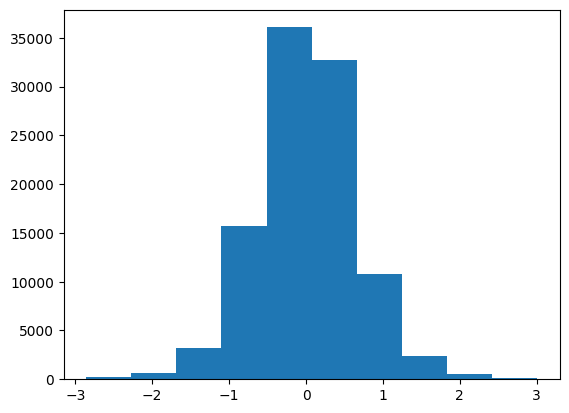

In [85]:
logit_hist = np.log(hist / (1-hist))
logit_pred = np.log(pred / (1-pred))
residul = logit_pred - logit_hist
residul = np.nan_to_num(residul, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(residul);


In [112]:
residul

array([ 0.82911861, -0.67083506, -0.30311028, ..., -0.01073337,
       -0.2620478 , -0.2620478 ])

In [108]:
h2h_train = np.array(h2h_rate[:26119 + 1])[:, 1]

In [109]:
h2h_train

array([       nan,        nan,        nan, ..., 0.53112295, 0.38664659,
       0.40382286])

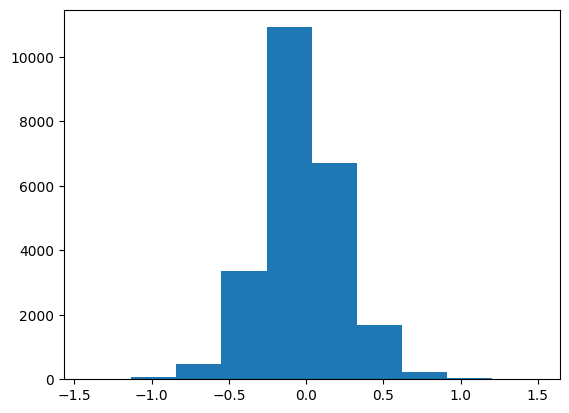

In [110]:
logit_h2h = np.log(h2h_train / (1-h2h_train))
logit_h2h = np.nan_to_num(logit_h2h, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(logit_h2h);


ValueError: x and y must have same first dimension, but have shapes (102424,) and (26120,)

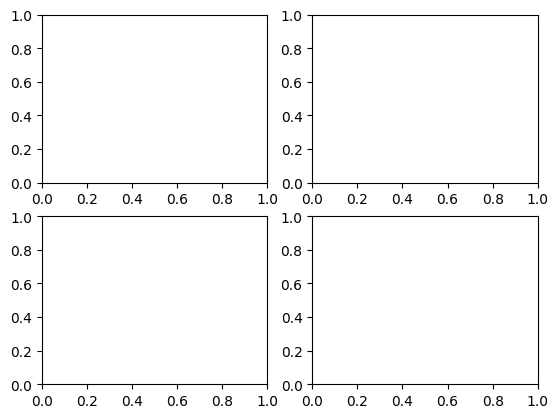

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2)

# Generate some test data
x, y = residul, h2h_train

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

In [40]:

def f(df, game_id):
    # Get the current match players
    match = df[df['ID'] == game_id]
    if len(match) != 2:
        raise ValueError("Game ID should have exactly 2 rows.")

    player1, player2 = match['Player'].values

    # Step 1: Get past matches (IDs smaller than the current match ID)
    past_matches = df[df['ID'] < game_id]

    # Step 2: Find all past matches where either player participated
    past_h2h = past_matches[past_matches['Player'].isin([player1, player2])]

    # Step 3: Keep only match IDs that appear exactly twice
    valid_h2h_ids = past_h2h['ID'].value_counts()
    valid_h2h_ids = valid_h2h_ids.index[valid_h2h_ids == 2]

    if valid_h2h_ids.empty:
        return 0.5, 0.5  # No history

    # Step 4: Filter only valid head-to-head matches
    past_h2h = past_h2h[past_h2h['ID'].isin(valid_h2h_ids)]

    # Step 5: Use GroupBy for efficiency
    match_grouped = past_h2h.groupby('ID')

    # Step 6: Compute Wins and Win Ratios Efficiently
    win_counts = {player1: 0, player2: 0}
    win_ratios = []

    for match_id, match_data in match_grouped:
        # Find winner & loser efficiently
        winner_idx = match_data['Game'].idxmax()
        loser_idx = match_data['Game'].idxmin()
        winner, loser = match_data.loc[winner_idx, 'Player'], match_data.loc[loser_idx, 'Player']
        win_counts[winner] += 1

        # Compute win ratio using vectorized operations
        match_data_set = match_data.loc[:, SETCOL + ['Player']].copy()
        match_data_set[SETCOL] = match_data_set[SETCOL].astype(float)

        # Compute sum of set scores for normalization
        set_sum = match_data_set[SETCOL].sum(axis=0)

        # Get Player 1’s row and compute ratio
        player1_set_ratio = (match_data_set.loc[match_data_set['Player'] == player1, SETCOL] / set_sum).dropna(axis=1)

        # Append mean win ratio
        if not player1_set_ratio.empty:
            win_ratios.append(player1_set_ratio.mean(axis=1).values[0])

    total_h2h_games = sum(win_counts.values())
    h2h_winrate = win_counts[player1] / total_h2h_games if total_h2h_games > 0 else 0.5
    avg_win_ratio = sum(win_ratios) / len(win_ratios) if win_ratios else None

    return h2h_winrate, avg_win_ratio


# Train and Evaluate

In [24]:
modelMElo = ModifiedElo()

# traing model with only training set
for _ in range(5):
    modelMElo.fit(X_train)


Training model: 100%|██████████| 26120/26120 [00:02<00:00, 11459.22it/s]


In [25]:
def evaluate(model, dataset):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False
    correct = 0
    n_matches = 0

    history = []
    predictions = []
    for matchi in tqdm(dataset, desc="Evaluating matches"):
        matchi = matchi.T
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_game(player1, player2)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue
        whowillwin = 0 if p > 0.5 else 1

        win1 = sum(matchi[2:, 0]>matchi[2:, 1])
        win2 = sum(matchi[2:, 0]<matchi[2:, 1])
        whowon = 0 if win1 > win2 else 1

        history.append(win1/(win1 + win2))
        predictions.append(p)

        n_matches += 1
        if (whowon == whowillwin): correct += 1

    acc = correct / n_matches
    print(f'\n === Accuracy: {acc} === \n\n')
    return acc, np.array(history), np.array(predictions)




def evaluate_point(model, dataset, h2h):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False

    history = []
    predictions = []
    h2hs = []
    for idx, matchi in tqdm(enumerate(dataset), desc="Evaluating matches"):

        matchi = matchi.T
        h2hi = h2h[idx]
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_point(player1, player2)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue
        whowillwin = 0 if p > 0.5 else 1

        for seti in matchi[2:]:
            if np.isnan(seti[0]) or (seti[0] + seti[1]) == 0: break
            winrate = seti[0] / (seti[0] + seti[1])
            history.append(winrate)
            predictions.append(p)
            h2hs.append(h2hi)


    return np.array(history), np.array(predictions), np.array(h2hs)



In [29]:
# evaluate the model with the evaluating set
# accMElo, historyMElo, predictionsMElo = evaluate(modelMElo, X_val);
accMElo, historyMElo, predictionsMElo = evaluate(modelMElo, X_train);


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 26120/26120 [00:01<00:00, 14757.81it/s]


 === Accuracy: 0.6505359877488515 === 




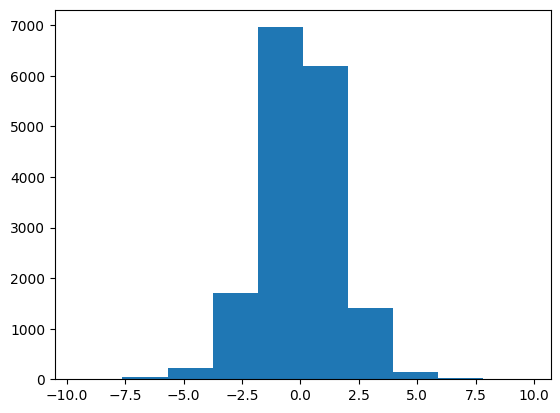

In [30]:
logit_hist = np.log(historyMElo / (1-historyMElo))
logit_pred = np.log(predictionsMElo / (1-predictionsMElo))
residul = logit_pred - logit_hist
residul = np.nan_to_num(residul, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(residul);


In [ ]:
for idx in df_train.ID.unique():
    df_i = df_train[df_train.ID == idx]
    print(df_i)
    player1, player2 = df_i.Player.values
    print(player1, player2)

    if idx == 100: break


   ID              Round           Datetime     Player Game        Date  \
0   0  Setka Cup (World)  2020.27.03. 14:40  Nerush L.    1  2020-03-27   
1   0  Setka Cup (World)  2020.27.03. 14:40  Nerush P.    3  2020-03-27   

       Time  Set1  Set2  Set3  Set4  Set5  Set6  
0  14:40:00   3.0  11.0  11.0   6.0   NaN   NaN  
1  14:40:00  11.0   9.0  13.0  11.0   NaN   NaN  
Nerush L. Nerush P.
   ID              Round           Datetime      Player Game        Date  \
2   1  Setka Cup (World)  2020.27.03. 15:10  Maliuta M.    3  2020-03-27   
3   1  Setka Cup (World)  2020.27.03. 15:10   Kregul O.    1  2020-03-27   

       Time  Set1  Set2  Set3  Set4  Set5  Set6  
2  15:10:00  11.0  11.0  11.0  11.0   NaN   NaN  
3  15:10:00   5.0   8.0  13.0   9.0   NaN   NaN  
Maliuta M. Kregul O.
   ID              Round           Datetime         Player Game        Date  \
4   2  Setka Cup (World)  2020.27.03. 15:40  Muliarchuk A.    0  2020-03-27   
5   2  Setka Cup (World)  2020.27.03. 15:40   

In [ ]:

SETCOL = [i for i in df_train.columns if 'Set' in i]
print(SETCOL)

def compute_h2h_stats(df, game_id):

    # Get the current match players
    match = df[df['ID'] == game_id]
    if len(match) != 2:
        raise ValueError("Game ID should have exactly 2 rows.")

    player1, player2 = match['Player'].values

    # Step 1: Get past matches (IDs smaller than the current match ID)
    past_matches = df[df['ID'] < game_id]

    # Step 2: Find all matches where either player participated
    past_h2h = past_matches[past_matches['Player'].isin([player1, player2])]

    # Step 3: Keep only match IDs that appear exactly twice (ensuring both players were in it)
    valid_h2h_ids = past_h2h['ID'].value_counts()
    valid_h2h_ids = valid_h2h_ids[valid_h2h_ids == 2].index  # Only matches where both appeared

    past_h2h = past_h2h[past_h2h['ID'].isin(valid_h2h_ids)]

    if past_h2h.empty:
        return 0.5, 0.5  # No history: return neutral probability, no wins/losses, no ratios

    # Step 4: Count wins and losses, and calculate win/loss ratios
    win_counts = {player1: 0, player2: 0}
    win_ratios = []

    for match_id in valid_h2h_ids:
        match_data = past_h2h[past_h2h['ID'] == match_id]

        winner = match_data.loc[match_data['Game'].idxmax(), 'Player']
        loser = match_data.loc[match_data['Game'].idxmin(), 'Player']

        # winner_score = float(match_data['Game'].max())
        # loser_score = float(match_data['Game'].min())
        match_data_set = match_data[SETCOL + ['Player']]
        match_data_set[SETCOL] = match_data_set[SETCOL].astype(float)
        match_data_set_ratio = (match_data_set[match_data_set.Player == player1][SETCOL] / match_data_set[SETCOL].sum(axis=0))
        win_ratios.append(match_data_set_ratio.dropna(axis=1).mean(axis=1).values[0])
        win_counts[winner] += 1



    total_h2h_games = sum(win_counts.values())
    h2h_winrate = win_counts[player1] / total_h2h_games if total_h2h_games > 0 else 0.5
    avg_win_ratio = sum(win_ratios) / len(win_ratios) if win_ratios else None
    return h2h_winrate, avg_win_ratio






def compute_h2h_stats2(df, game_id):
    # Get the current match players
    match = df[df['ID'] == game_id]
    if len(match) != 2:
        raise ValueError("Game ID should have exactly 2 rows.")

    player1, player2 = match['Player'].values

    # Step 1: Get past matches (IDs smaller than the current match ID)
    past_matches = df[df['ID'] < game_id]

    # Step 2: Find all past matches where either player participated
    past_h2h = past_matches[past_matches['Player'].isin([player1, player2])]

    # Step 3: Keep only match IDs that appear exactly twice
    valid_h2h_ids = past_h2h['ID'].value_counts()
    valid_h2h_ids = valid_h2h_ids.index[valid_h2h_ids == 2]

    if valid_h2h_ids.empty:
        return 0.5, 0.5  # No history

    # Step 4: Filter only valid head-to-head matches
    past_h2h = past_h2h[past_h2h['ID'].isin(valid_h2h_ids)]

    # Step 5: Use GroupBy for efficiency
    match_grouped = past_h2h.groupby('ID')

    # Step 6: Compute Wins and Win Ratios Efficiently
    win_counts = {player1: 0, player2: 0}
    win_ratios = []

    for match_id, match_data in match_grouped:
        # Find winner & loser efficiently
        winner_idx = match_data['Game'].idxmax()
        loser_idx = match_data['Game'].idxmin()
        winner, loser = match_data.loc[winner_idx, 'Player'], match_data.loc[loser_idx, 'Player']
        win_counts[winner] += 1

        # Compute win ratio using vectorized operations
        match_data_set = match_data.loc[:, SETCOL + ['Player']].copy()
        match_data_set[SETCOL] = match_data_set[SETCOL].astype(float)

        # Compute sum of set scores for normalization
        set_sum = match_data_set[SETCOL].sum(axis=0)

        # Get Player 1’s row and compute ratio
        player1_set_ratio = (match_data_set.loc[match_data_set['Player'] == player1, SETCOL] / set_sum).dropna(axis=1)

        # Append mean win ratio
        if not player1_set_ratio.empty:
            win_ratios.append(player1_set_ratio.mean(axis=1).values[0])

    total_h2h_games = sum(win_counts.values())
    h2h_winrate = win_counts[player1] / total_h2h_games if total_h2h_games > 0 else 0.5
    avg_win_ratio = sum(win_ratios) / len(win_ratios) if win_ratios else None

    return h2h_winrate, avg_win_ratio


In [ ]:
df_train_n = df_train[df_train.ID < 5000]

In [ ]:
h2h_train = []
h2h_val = []


# for idx in tqdm(df_train_n.ID.unique()):
#     h2h_train.append(compute_h2h_stats2(df_train, idx))

for idx in tqdm(df_val.ID.unique()):
    h2h_val.append(compute_h2h_stats2(df_val, idx))

# h2h_train = np.array(h2h_train)

h2h_val = np.array(h2h_val)

100%|██████████| 6490/6490 [12:15<00:00,  8.82it/s]


In [ ]:
X_train_n = X_train[:5000]
accMElo, historyMElo, predictionsMElo = evaluate(modelMElo, X_train_n);

Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 5000/5000 [00:00<00:00, 24612.76it/s]


 === Accuracy: 0.5976 === 




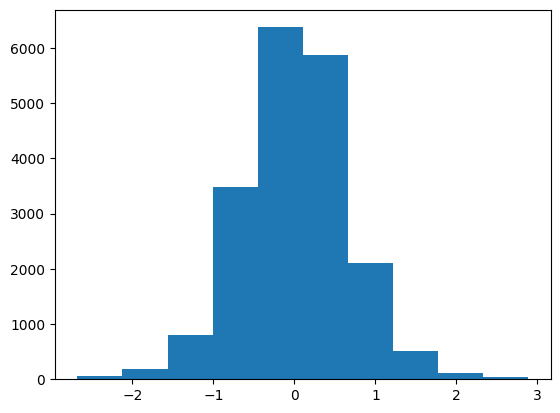

In [ ]:
logit_hist = np.log(historyMElo / (1-historyMElo))
logit_pred = np.log(predictionsMElo / (1-predictionsMElo))
residul = logit_pred - logit_hist
residul = np.nan_to_num(residul, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(residul);


In [ ]:
rate = h2h_train[:, 1]
rate_logit = np.log(rate / (1-rate))

comb = np.array([residul, rate_logit])
comb = comb[:, ~np.isnan(comb).any(axis=0)]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
comb = comb[:, ~(abs(comb)<=1e-10).any(axis=0)]
comb = comb[:, ~(abs(comb)>=1e10).any(axis=0)]

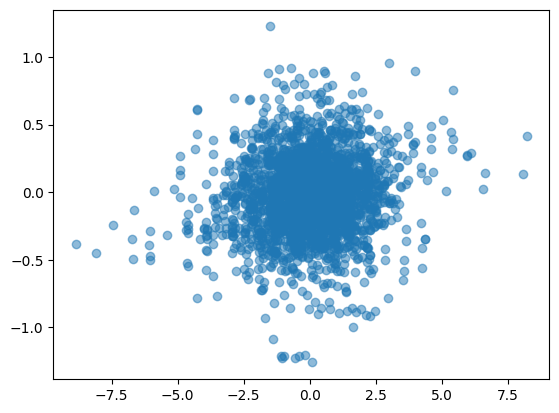

In [ ]:
plt.scatter(comb[0], comb[1], alpha=0.5)

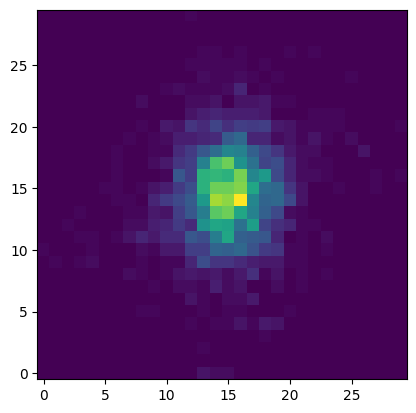

In [ ]:
heatmap, xedges, yedges = np.histogram2d(comb[0], comb[1], bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

# Fit Linear Regression Model
model = LinearRegression()
model.fit(comb[0].reshape(-1, 1), comb[1])

# Print Model Coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")


Intercept: -0.021746676310936238
Coefficients: [0.01844901]


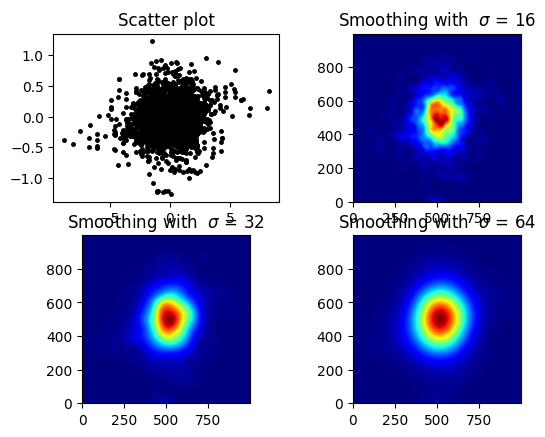

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2)

# Generate some test data
x, y = comb[0], comb[1]

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

In [ ]:
def evaluate_point(model, dataset, h2h):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False

    history = []
    predictions = []
    h2hs = []
    for idx, matchi in tqdm(enumerate(dataset), desc="Evaluating matches"):

        matchi = matchi.T
        h2hi = h2h[idx]
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_point(player1, player2)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue
        whowillwin = 0 if p > 0.5 else 1

        for seti in matchi[2:]:
            if np.isnan(seti[0]) or (seti[0] + seti[1]) == 0: break
            winrate = seti[0] / (seti[0] + seti[1])
            history.append(winrate)
            predictions.append(p)
            h2hs.append(h2hi)


    return np.array(history), np.array(predictions), np.array(h2hs)



In [ ]:
# historyMElo, predictionsMElo, h2hsMElo = evaluate_point(modelMElo, X_train_n, h2h_train);
historyMElo, predictionsMElo, h2hsMElo = evaluate_point(modelMElo, X_val, h2h_val);

Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 6490it [00:00, 69586.44it/s]


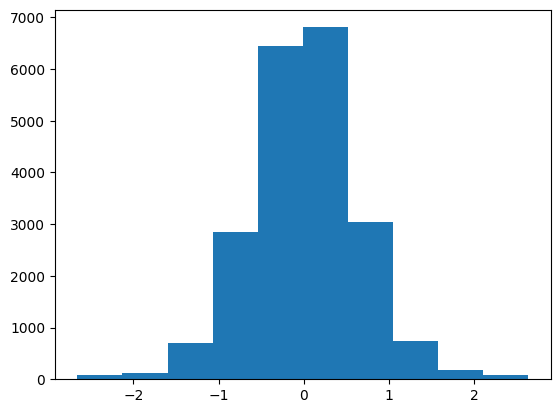

In [ ]:
logit_hist = np.log(historyMElo / (1-historyMElo))
logit_pred = np.log(predictionsMElo / (1-predictionsMElo))
residul = logit_hist - logit_pred
residul = np.nan_to_num(residul, nan=np.nan, posinf=np.nan, neginf=np.nan)
plt.hist(residul);


In [ ]:
rate = h2hsMElo[:, 1]
rate_logit = np.log(rate / (1-rate))

comb = np.array([residul, rate_logit])
comb = comb[:, ~np.isnan(comb).any(axis=0)]

In [ ]:
comb = comb[:, ~(abs(comb)<=1e-10).any(axis=0)]
comb = comb[:, ~(abs(comb)>=1e10).any(axis=0)]

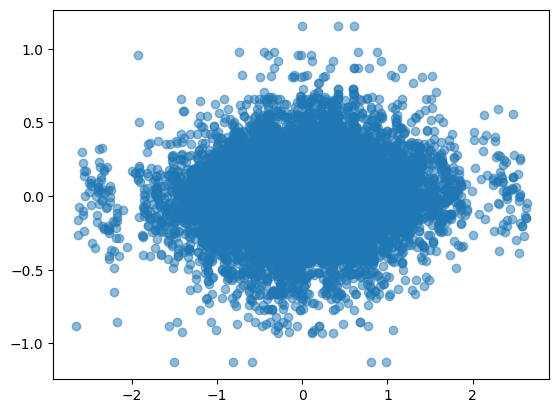

In [ ]:
plt.scatter(comb[0], comb[1], alpha=0.5)

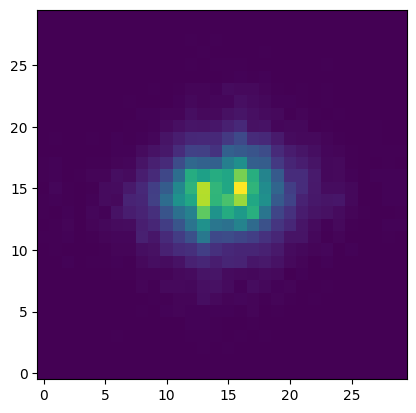

In [ ]:
heatmap, xedges, yedges = np.histogram2d(comb[0], comb[1], bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

# Fit Linear Regression Model
model = LinearRegression()
model.fit(comb[0].reshape(-1, 1), comb[1])

# Print Model Coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")


Intercept: 0.002921078960117566
Coefficients: [0.03117521]


In [ ]:
import statsmodels.api as sm
x = comb[1]
# x = sm.add_constant(x)
ols = sm.OLS(comb[0].reshape(-1, 1), x)
ols_result = ols.fit()
print(ols_result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              165.4
Date:                Sat, 08 Feb 2025   Prob (F-statistic):                    1.08e-37
Time:                        17:30:27   Log-Likelihood:                         -18856.
No. Observations:               19560   AIC:                                  3.771e+04
Df Residuals:                   19559   BIC:                                  3.772e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

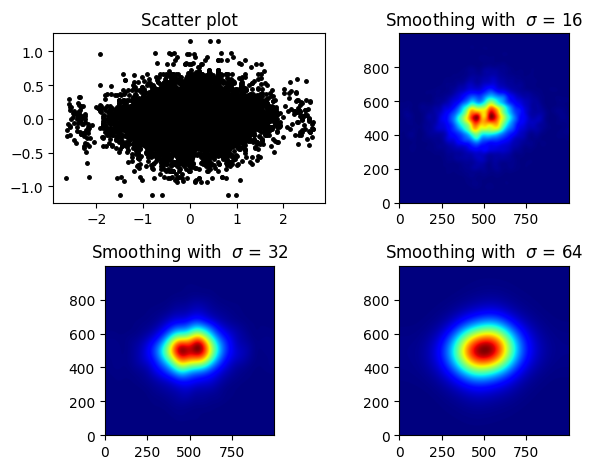

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2)

# Generate some test data
x, y = comb[0], comb[1]

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.tight_layout()
plt.show()